In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/utils")
import NeuGNN_model
import Self_func
import Interaction_func
from NeuGNN_model import *
from Self_func import *
from Interaction_func import *

In [3]:
USE_CUDA = False

In [4]:
Timeseries = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Time series/flocks_timeseries_2dim_hf1.csv',encoding='utf-8',header=None)

In [5]:
Adj = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Topology/adj_hf1_7.csv',encoding='utf-8',header=None)

In [6]:
model = 'flocks'

In [7]:
Num_nodes = Adj.shape[0]
Dimension = int(Timeseries.shape[1]/Num_nodes)

In [8]:
time = Timeseries.values
timeseries = time.reshape(( -1, Num_nodes, Dimension)) # checked, correct input data

In [9]:
delt_t = 0.01

In [10]:
timeseries_t0 = timeseries[0:-1,:,:]
timeseries_t1 = timeseries[1:,:,:]
dX = (timeseries_t1-timeseries_t0)
dXdt = (timeseries_t1-timeseries_t0)/delt_t

In [11]:
timeseries_t2 = timeseries[2:,:,:]
dVdt = (timeseries_t2-2*timeseries_t1[:-1,:,:]+timeseries[0:-2,:,:])/delt_t**2

In [12]:
import numpy as np
def get_edge_index(Adj):
    num_nodes = Adj.shape[0]
    Adj = Adj.values
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

In [13]:
edge_index = get_edge_index(Adj) #target to source

index = [1,0]
edge_index = edge_index[index] #source to target 
# checked, correct input edge_index data

In [14]:
#data = data.reshape((10,-1,4,6))
import numpy as np
goal_data = np.concatenate([timeseries[3:,:,:],dXdt[1:-1,:,:],dVdt[:-1,:,:]],axis=2)
#goal_data = data[1:-1,:,0:Dimension]
mapping_data = np.concatenate((timeseries[1:-2,:,:],dXdt[0:-2,:,:]),axis=2)

In [15]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [18]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [19]:
aggr = 'add'
hidden = 100

msg_dim = 3
n_f = mapping_data.shape[2]

In [20]:
dim = Dimension*1

In [21]:
from torch_geometric.data import Data, DataLoader

In [23]:
ogn = SDI_Difftype(model,n_f, msg_dim, dim, delt_t, hidden=hidden, edge_index=edge_index , aggr=aggr)

In [24]:
messages_over_time = []
selfDyn_over_time = []
diffusion_over_time = []

In [25]:
x=X_train[1]
y=y_train[1]
_q = Data(
    x=X_train[1],
    edge_index=edge_index,
    y=y_train[1])

In [26]:
ogn.loss(_q)

tensor(237.4711, grad_fn=<AddBackward0>)

In [27]:
batch = 64
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=128,
    shuffle=True
)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [28]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [29]:
init_lr = 1e-4

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 30

batch_per_epoch = 2000

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

In [30]:
epoch = 0
from tqdm import tqdm

In [31]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

In [32]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source

        s2 = tmp.x[tmp.edge_index[1]] #target

        #Tmp = torch.cat([s2, s1],dim=1) # tmp --> xi,xj
        xtmp = (s1[:,0:dim]-s2[:,0:dim])
        vtmp = (s1[:,dim:dim*2]-s2[:,dim:dim*2])
        if dim == 1:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2)
        if dim == 2:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2+(s1[:,1]-s2[:,1])**2)
        if dim == 3:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2+(s1[:,1]-s2[:,1])**2+(s1[:,2]-s2[:,2])**2)
 
        cohesion = ogn.msg_fnc_cohesion(Xtmp.reshape(-1,1))
        align = ogn.msg_fnc_align(Xtmp.reshape(-1,1))
        #repulsion = ogn.msg_fnc_repulsion(Xtmp.reshape(-1,1))
    
        all_messages = torch.cat((
            xtmp,vtmp,cohesion,align), dim=1)
        if dim == 1:
            columns = ['xij','dxij','c1','a1']
        if dim == 2:
            columns = ['xij','yij','dxij','dyij','c1','a1']
        elif dim == 3:
            columns = ['xij','yij','zij','dxij','dyij','dzij','c1','a1']

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [33]:
def get_diffusion(ogn):
    def get_diffusion_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x), dim=1)
            columns = ['xi','dxi','d1']
            
        if dim==2:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y), dim=1)
            columns = ['xi','yi','dxi','dyi','d1','d2']
        if dim==3:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_z = ogn.stochastic_z(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y,self_diff_z), dim=1)
            columns = ['xi','yi','zi','dxi','dyi','dzi','d1','d2','d3']
            
        return pd.DataFrame(
              data=self_diff_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_diff_all)

    selfDiffusion_info = []
    for i, g in enumerate(newtestloader):
        selfDiffusion_info.append(get_diffusion_info(g))

    selfDiffusion_info = pd.concat(selfDiffusion_info)
    return selfDiffusion_info 

In [34]:
def get_selfDynamics(ogn):
    def get_selfDynamics_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            vtmp = torch.sqrt(tmp[:,1]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1,1))
            self_dyn_all = torch.cat((tmp[:,1:2],self_dyn), dim=1)
            columns = ['dxi','s1']
            
        if dim==2:
            vtmp = tmp[:,2]**2+tmp[:,3]**2
            vxtmp = torch.cat((vtmp.reshape(-1,1),tmp[:,2].reshape(-1,1)),dim=1)
            vytmp = torch.cat((vtmp.reshape(-1,1),tmp[:,3].reshape(-1,1)),dim=1)
            
            self_dyn_x = ogn.node_fnc_strength_x(vxtmp)#vtmp.reshape(-1,1)
            self_dyn_y = ogn.node_fnc_strength_y(vytmp)#vtmp.reshape(-1,1)
            self_dyn_all = torch.cat((vtmp.reshape(-1,1),tmp[:,2:4],self_dyn_x, self_dyn_y), dim=1)
            columns = ['Vi','dxi','dyi','s1','s2']
        if dim==3:
            vtmp = torch.sqrt(tmp[:,3]**2+tmp[:,4]**2+tmp[:,5]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1,1))
            self_dyn_all = torch.cat((tmp[:,3:6],self_dyn), dim=1)
            columns = ['dxi','dyi','dzi','s1']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(newtestloader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info

In [35]:
recorded_models = []

In [36]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x
            ginput.y = ginput.y
            ginput.edge_index = ginput.edge_index
            ginput.batch = ginput.batch
            loss = ogn.loss(ginput)
            loss.backward()
            #(loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)
    
    ogn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                if j>= batch_per_epoch:
                    break
                ginput.x = ginput.x
                ginput.y = ginput.y
                ginput.edge_index = ginput.edge_index
                ginput.batch = ginput.batch
                loss = ogn.loss(ginput)#/int(ginput.batch[-1]+1)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1]+1)
                j += 1



    cur_loss = total_loss/num_items
    cur_valid_loss = valid_loss/valid_num_items
    print(cur_loss)
    print(cur_valid_loss)
    cur_msgs = get_messages(ogn)
    cur_selfdyn = get_selfDynamics(ogn)
    cur_diff = get_diffusion(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    selfDyn_over_time.append(cur_selfdyn)
    diffusion_over_time.append(cur_diff)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(copy(ogn.state_dict()))

  0%|                                                    | 0/30 [00:00<?, ?it/s]

16.886324508983144
7.129246380567551


  3%|█▍                                          | 1/30 [01:36<46:29, 96.21s/it]

5.454289934442111
2.9272380797863007


  7%|██▉                                         | 2/30 [03:11<44:34, 95.52s/it]

-2.9331961756387543
-11.70557255077362


 10%|████▍                                       | 3/30 [04:46<42:52, 95.29s/it]

-29.731482073025294
-54.11268090438843


 13%|█████▊                                      | 4/30 [06:21<41:14, 95.17s/it]

-90.39812007770415
-125.01600299072265


 17%|███████▎                                    | 5/30 [07:56<39:38, 95.13s/it]

-122.59385984048772
-83.74617567253112


 20%|████████▊                                   | 6/30 [09:31<38:02, 95.10s/it]

-126.66418908037929
-120.16313842391968


 23%|██████████▎                                 | 7/30 [11:06<36:27, 95.10s/it]

-127.291959131996
-132.7039454727173


 27%|███████████▋                                | 8/30 [12:41<34:51, 95.07s/it]

-127.51283230744748
-132.46480212020873


 30%|█████████████▏                              | 9/30 [14:16<33:15, 95.03s/it]

-129.57969397268258
-133.08702547073364


 33%|██████████████▎                            | 10/30 [15:51<31:40, 95.03s/it]

-132.7466620804053
-139.6257727432251


 37%|███████████████▊                           | 11/30 [17:26<30:06, 95.06s/it]

-135.00727747747266
-6.806672182791866


 40%|█████████████████▏                         | 12/30 [19:01<28:31, 95.06s/it]

-136.06998888434958
-142.99823052978516


 43%|██████████████████▋                        | 13/30 [20:38<27:07, 95.72s/it]

-139.7061023674606
-131.23105696487426


 47%|████████████████████                       | 14/30 [22:16<25:42, 96.42s/it]

-141.53546272925635
-147.13988737487793


 50%|█████████████████████▌                     | 15/30 [23:53<24:08, 96.53s/it]

-145.0227908138603
-148.98360594177245


 53%|██████████████████████▉                    | 16/30 [25:31<22:34, 96.77s/it]

-147.4648897892021
-149.7966641921997


 57%|████████████████████████▎                  | 17/30 [27:07<20:56, 96.63s/it]

-150.2661997636164
-151.1634369430542


 60%|█████████████████████████▊                 | 18/30 [28:43<19:17, 96.46s/it]

-153.76608914299874
-156.20881846618653


 63%|███████████████████████████▏               | 19/30 [30:20<17:41, 96.52s/it]

-157.13059073180875
-139.22895987701415


 67%|████████████████████████████▋              | 20/30 [31:56<16:04, 96.41s/it]

-161.20742370496745
-165.66839115905762


 70%|██████████████████████████████             | 21/30 [33:32<14:27, 96.40s/it]

-164.37386585124608
-168.00013132476806


 73%|███████████████████████████████▌           | 22/30 [35:07<12:48, 96.01s/it]

-168.0341269285881
-171.56091278076173


 77%|████████████████████████████████▉          | 23/30 [36:42<11:10, 95.80s/it]

-170.89067295987277
-173.37116506195068


 80%|██████████████████████████████████▍        | 24/30 [38:19<09:36, 96.01s/it]

-173.1742123227972
-174.27684331512452


 83%|███████████████████████████████████▊       | 25/30 [39:55<07:59, 95.96s/it]

-174.75577259555473
-175.6066721801758


 87%|█████████████████████████████████████▎     | 26/30 [41:30<06:23, 95.85s/it]

-175.762361996725
-176.11823919677735


 90%|██████████████████████████████████████▋    | 27/30 [43:06<04:46, 95.64s/it]

-176.31684740300722
-176.7342202606201


 93%|████████████████████████████████████████▏  | 28/30 [44:41<03:11, 95.52s/it]

-176.65988001913877
-176.70322192382812


 97%|█████████████████████████████████████████▌ | 29/30 [46:16<01:35, 95.44s/it]

-176.80192252864592
-176.92287308502196


100%|███████████████████████████████████████████| 30/30 [47:51<00:00, 95.72s/it]


In [72]:
ogn.cpu()
ogn.load_state_dict(recorded_models[-1])

<All keys matched successfully>

In [73]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))
x_Update = []
y_Update = []
z_Update = []
vx_Update = []
vy_Update = []
vz_Update = []
for i in range(0,20000):#X.shape[0]
    _q = Data(
        x=X[i].float(),
        edge_index=edge_index,
        y=y[i].float())
    x_tmp,v_tmp= ogn.sample_trajectories(_q)
    if i < X.shape[0]-2:
        X[i+2,:,0:dim] = x_tmp
        
        X[i+1,:,dim:] = v_tmp
    else:
        break
    x_Update.append(x_tmp[:,0].reshape(1,-1))
    y_Update.append(x_tmp[:,1].reshape(1,-1))
    #z_Update.append(x_tmp[:,2].reshape(1,-1))
    vx_Update.append(v_tmp[:,0].reshape(1,-1))
    vy_Update.append(v_tmp[:,1].reshape(1,-1))
    #vz_Update.append(v_tmp[:,2].reshape(1,-1))
x_i = torch.stack(x_Update, dim=0).reshape(-1,Num_nodes)
y_i = torch.stack(y_Update, dim=0).reshape(-1,Num_nodes)
#z_i = torch.stack(z_Update, dim=0).reshape(-1,Num_nodes)
vx_i = torch.stack(vx_Update, dim=0).reshape(-1,Num_nodes)
vy_i = torch.stack(vy_Update, dim=0).reshape(-1,Num_nodes)
#vz_i = torch.stack(vz_Update, dim=0).reshape(-1,Num_nodes)

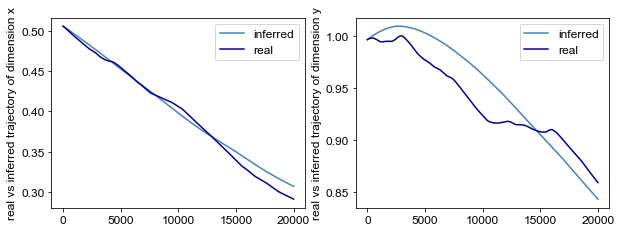

In [74]:
time1 = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/pigeonflocks_trajectories/hf1/flocks_timeseries_2dim_hf1.csv',encoding='utf-8',header=None)
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
#plt.rcParams['savefig.dpi'] = 300 
#plt.rcParams['figure.dpi'] = 300
Nindex =0
TIME = 20000
x_tra = x_i.detach().numpy()[0:TIME,Nindex-1]
x_real = time1.iloc[0:,Nindex*2-2]
fig = plt.figure(figsize=(10,3.5))
ax1 = fig.add_subplot(1,2,1)
t = np.arange(0,x_tra.shape[0])
ax1.plot(t,x_tra,c='steelblue',label="inferred")
ax1.plot(t, x_real[2:x_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension x')
plt.legend()

ax2 = fig.add_subplot(1,2,2)
y_tra = y_i.detach().numpy()[0:TIME,Nindex-1]
y_real = time1.iloc[0:,Nindex*2-1]
t = np.arange(0,y_tra.shape[0])
ax2.plot(t,y_tra,c='steelblue',label="inferred")
ax2.plot(t, y_real[2:y_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension y')
plt.legend()

#plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticRossler/Figures/weightedRossler_intensity01_average_trajectories.png')
plt.show()
#plt.close()

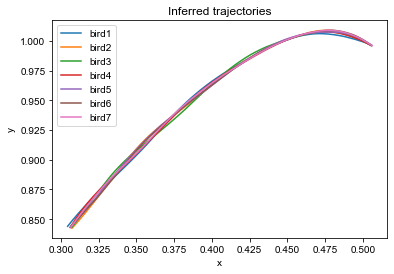

In [95]:
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

r = np.linspace(0, 200, 20000)
fig, ax = plt.subplots()
x1 = x_i.detach().numpy()[0:TIME,0]
y1 = y_i.detach().numpy()[0:TIME,0]
ax.plot(x1, y1, label='bird1')
#ax.scatter(x1, y1, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x2 = x_i.detach().numpy()[0:TIME,1]
y2 = y_i.detach().numpy()[0:TIME,1]
ax.plot(x2, y2, label='bird2')
#ax.scatter(x2, y2, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x3 = x_i.detach().numpy()[0:TIME,2]
y3 = y_i.detach().numpy()[0:TIME,2]
ax.plot(x3, y3, label='bird3')
#ax.scatter(x3, y3, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x4 = x_i.detach().numpy()[0:TIME,3]
y4 = y_i.detach().numpy()[0:TIME,3]
ax.plot(x4, y4, label='bird4')
#ax.scatter(x4, y4, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x5 = x_i.detach().numpy()[0:TIME,4]
y5 = y_i.detach().numpy()[0:TIME,4]
ax.plot(x5, y5, label='bird5')
#ax.scatter(x5, y5, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x6 = x_i.detach().numpy()[0:TIME,5]
y6 = y_i.detach().numpy()[0:TIME,5]
ax.plot(x6, y6, label='bird6')
#ax.scatter(x6, y6, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x7 = x_i.detach().numpy()[0:TIME,6]
y7 = y_i.detach().numpy()[0:TIME,6]
ax.plot(x7, y7, label='bird7')
#ax.scatter(x7, y7, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)

# x = x_real[1:20001,]
# y = y_real[1:20001,]
# ax.scatter(x, y, c = plt.cm.YlGnBu(r/max(r)),alpha=0.5, s= 1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Inferred trajectories')
ax.legend()
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf1_inferred.pdf')
plt.show()

/var/folders/tx/qq1ds3m144q1b4ghn62l4kjc0000gn/T/ipykernel_35688/2751892123.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


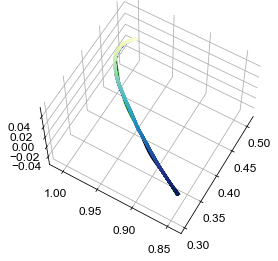

In [40]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.azim = -150
ax.dist = 9
ax.elev = 60
r = np.linspace(0, 200, 20000)


x_tra_1 = x_i.detach().numpy()[0:TIME,Nindex+1]
y_tra_1 = y_i.detach().numpy()[0:TIME,Nindex+1]
#z_tra_1 = z_i.detach().numpy()[0:TIME,Nindex+1]
x = x_tra_1#x_real[1:x_tra.shape[0]+1,]
y = y_tra_1#y_real[1:y_tra.shape[0]+1,]
#z = z_tra_1#z_real[1:z_tra.shape[0]+1,]

x_tra_2 = x_i.detach().numpy()[0:TIME,Nindex+2]
y_tra_2 = y_i.detach().numpy()[0:TIME,Nindex+2]
#z_tra_2 = z_i.detach().numpy()[0:TIME,Nindex+2]
x2 = x_tra_2#x_real[1:x_tra.shape[0]+1,]
y2 = y_tra_2 #y_real[1:y_tra.shape[0]+1,]
#z2 = z_tra_2#z_real[1:z_tra.shape[0]+1,]

x_tra_3 = x_i.detach().numpy()[0:TIME,Nindex+3]
y_tra_3 = y_i.detach().numpy()[0:TIME,Nindex+3]
#z_tra_3 = z_i.detach().numpy()[0:TIME,Nindex+3]
x3 = x_tra_3#x_real[1:x_tra.shape[0]+1,]
y3 = y_tra_3 #y_real[1:y_tra.shape[0]+1,]
#z3 = z_tra_3#z_real[1:z_tra.shape[0]+1,]


x1 = x_tra
y1 = y_tra
#z1 = z_tra

#1 colored by value of `z`
ax.plot(x, y, c = 'k') 
ax.plot(x2, y2, c = 'g') 
ax.plot(x3, y3, c = 'b') 
#2 colored by index (same in this example since z is a linspace too)

ax.scatter(x1, y1, c = plt.cm.YlGnBu(r/max(r)),alpha=0.5, s= 3)

plt.show()

In [139]:
bestMe = messages_over_time[-1]

In [140]:
rij_val = np.sqrt(bestMe['xij'].values**2+bestMe['yij'].values**2)
#cohesion_true = 1.5*(1-(rij_val/2)**3)/(1+(rij_val/2)**6) # x1 (x_i) is target, x2 (x_j) is source 
align_true = np.exp(-rij_val/3)#np.sin(bestMe['x2'].values-bestMe['x1'].values)

In [141]:
maxy = np.max(bestMe['a1'].values)
miny = np.min(bestMe['a1'].values)
maxx = np.max(align_true)
minx = np.min(align_true)
align_true = (maxy-miny)*(align_true-minx)/(maxx-minx) + miny

In [142]:
(maxy-miny)/(maxx-minx)

0.60338336

In [143]:
minx

0.9954246

In [144]:
maxx-minx

0.004572034

In [145]:
miny

-0.0032163374

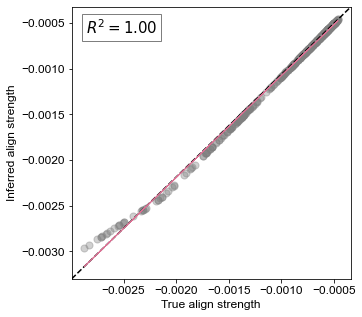

In [146]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sx = bestMe['a1'].values[0:1000]#*bestMe['dxij']*m2
sx_true = align_true[0:1000]#*bestMe['dxij']
sy = bestMe['a1'].values[0:5000]#*bestMe['dyij']*m2
sy_true = align_true[0:5000]#*bestMe['dyij']
#sz = bestMe['a1'].values#*bestMe['dzij']*m2
#sz_true = align_true#*bestMe['dzij']
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1,1,1)
#plt.title("true align- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=50,c ='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True align strength")
plt.ylabel("Inferred align strength")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf1_align.pdf')

In [147]:
coup_value = -((rij_val/2-1)**3/(1+rij_val/2)**6)+1
#coup_value = ((rij_val/0.1)**3-1)/((rij_val/0.1)**6+1)

In [148]:
maxy = np.max(bestMe['c1'].values)
miny = np.min(bestMe['c1'].values)
maxx = np.max(coup_value)
minx = np.min(coup_value)
coup_value = (maxy-miny)*(coup_value-minx)/(maxx-minx) + miny

In [149]:
coup_value

array([0.00081312, 0.00086719, 0.0008042 , ..., 0.00086325, 0.00085529,
       0.00084265], dtype=float32)

In [150]:
-0.0070417193*(((rij_val/2-1)**3/(1+rij_val/2)**6)-1+1.9400337)+0.000451006

array([0.00081312, 0.00086719, 0.0008042 , ..., 0.00086325, 0.00085529,
       0.00084265], dtype=float32)

In [151]:
(maxy-miny)/(maxx-minx)

0.0070417193

In [152]:
minx

1.9400337

In [153]:
maxx-minx

0.059921265

In [154]:
miny

0.000451006

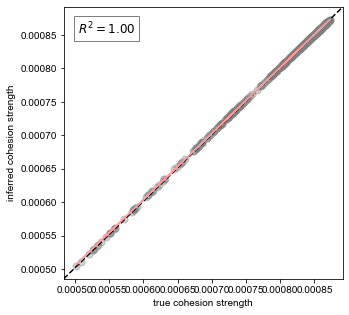

In [155]:
plt.rcParams.update({'font.size': 10}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
temp = bestMe['c1'].values[0:1000]
coup_value = coup_value[0:1000]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(coup_value,temp,s=50,c ='grey', alpha=0.2)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
parameter = np.polyfit(coup_value,temp,1)
f = np.poly1d(parameter)
ax.plot(coup_value,f(coup_value),c = '#ff9999', lw=1.5)
corr = np.corrcoef(coup_value,temp)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corr**2),transform=ax.transAxes, size=12, bbox=bbox)
#plt.title('Relation-rij-cohesion')
plt.xlabel("true cohesion strength")
plt.ylabel("inferred cohesion strength")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf1_cohesion.pdf')

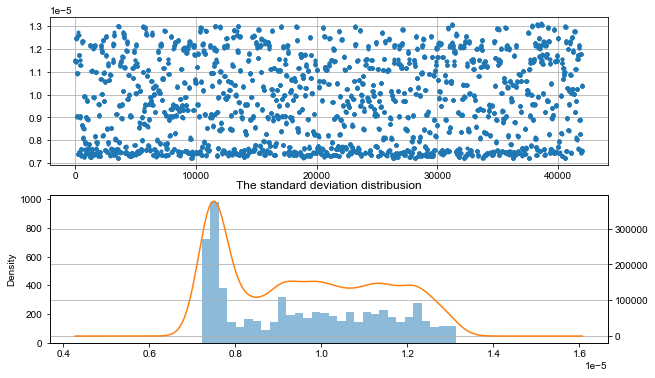

In [57]:
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, keep='first', inplace=False)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

s = diffusion_new['d1']/np.sqrt(0.01) # diffusion is sqrt(h)*theta(x0) 

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1)
#ax1.scatter(s.index, s.values)
ax1.plot(s.index, s.values,'.')
plt.grid()
 
ax2 = fig.add_subplot(2,1,2) 
s.hist(bins=30,alpha = 0.5,ax = ax2)
s.plot(kind = 'kde', secondary_y=True,ax = ax2)
plt.title('The standard deviation distribusion')
plt.grid()

In [58]:
best_selfDyn = selfDyn_over_time[-1]
best_selfDyn = pd.DataFrame(best_selfDyn)
TimeSeries = best_selfDyn.iloc[:,0:dim].values
TimeSeries = TimeSeries.reshape(-1,Dimension)

In [59]:
best_selfDyn

,Vi,dxi,dyi,s1,s2
0,0.000002,-0.000063,-0.001500,-0.000014,-0.000055
1,0.000002,-0.000063,-0.001500,-0.000014,-0.000055
2,0.000002,-0.000063,-0.001500,-0.000014,-0.000055
3,0.000002,-0.000063,-0.001500,-0.000014,-0.000055
4,0.000002,-0.000063,-0.001500,-0.000014,-0.000055
...,...,...,...,...,...
41995,0.000002,-0.000501,-0.001388,-0.000013,-0.000056
41996,0.000002,-0.000501,-0.001388,-0.000013,-0.000056
41997,0.000002,-0.000501,-0.001388,-0.000013,-0.000056
41998,0.000002,-0.000501,-0.001388,-0.000013,-0.000056


In [60]:
self_true = (best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)
#self_true = best_selfDyn['dxi']*best_selfDyn['Vi']
self_true_1 = np.sqrt(best_selfDyn['Vi'])*best_selfDyn['dxi']
self_true_2 = best_selfDyn['dxi']

In [61]:
maxy = np.max(best_selfDyn['s1'].values)
miny = np.min(best_selfDyn['s1'].values)
maxx = np.max(self_true)
minx = np.min(self_true)
self_true = (maxy-miny)*(self_true-minx)/(maxx-minx) + miny

In [62]:
(maxy-miny)/(maxx-minx)

1.9591489127252002

In [63]:
minx

1.2232491144459345e-06

In [64]:
maxx-minx

2.6164419750784873e-06

In [65]:
miny

-1.5962869e-05

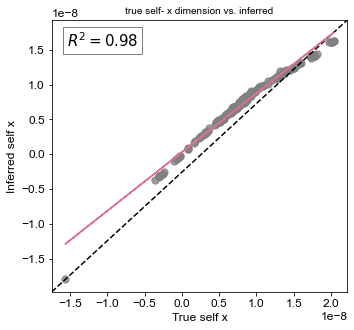

In [156]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#self_true = 0.4*(-np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2))
ri = np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)
sx = best_selfDyn['s1'].values*best_selfDyn['dxi']
sx_true = self_true*best_selfDyn['dxi']
sx = sx[0:1000]
sx_true = sx_true[0:1000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=50,c ='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1.5)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf1_self.pdf')

In [67]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

self_true_1 = np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)#*best_selfDyn['dxi']
self_true_2 = best_selfDyn['dxi']
Xfind = self_true_1.values.reshape(-1,1)#pd.concat([self_true_1,self_true_2],axis=1)
yfind = best_selfDyn['s1'].values
model_linear = LinearRegression(fit_intercept=True)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_

In [68]:
a

array([-0.00267166], dtype=float32)

In [69]:
model_linear.score(Xfind,yfind)

0.11204331390284483